# Using _egobox_ surrogate model _SparseGpx_

This tutorial is inspired from SGP tutorial from [SMT](https://github.com/SMTOrg/smt/tutorial).

## Installation

In [1]:
%pip install egobox

Note: you may need to restart the kernel to use updated packages.


We import _egobox_ as _egx_ for short

In [2]:
import egobox as egx

# Example 1 : SparseGpx basics

### Training 

#### Benchmark function definition

In [3]:
import numpy as np

def f_obj(x):
    return np.sin(3*np.pi*x) + 0.3*np.cos(9*np.pi*x) + 0.5*np.sin(7*np.pi*x)

#### Training data definition

In [4]:
# number of observations
N = 200

# noise
eta = 0.01

# Set seed via random generator for reproducibility
rng = np.random.RandomState(0)

# generate data
xt = 2*rng.rand(N, 1) - 1
yt = f_obj(xt) + rng.normal(loc=0.0, scale=np.sqrt(eta), size=(N,1))

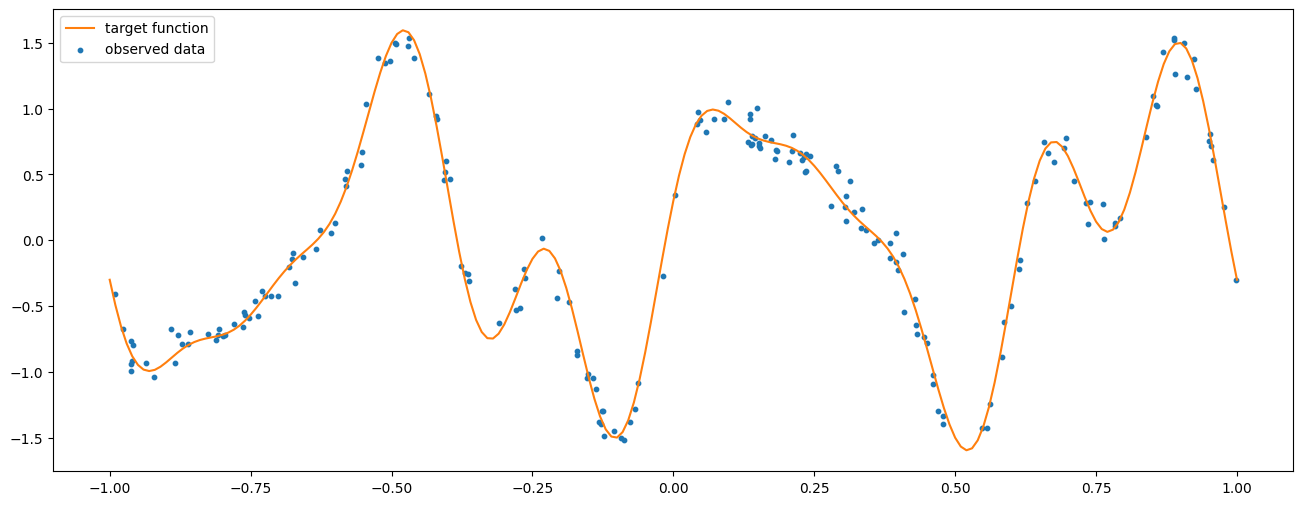

In [5]:
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 201).reshape(-1,1)
y = f_obj(x)

plt.figure(figsize=(16, 6))
plt.plot(x, y, "C1-", label="target function")
plt.scatter(xt, yt, marker="o", s=10, label="observed data")
plt.xlim([-1.1,1.1])
plt.legend(loc=0)
plt.show()

#### Building the surrogate

In order to ensure the proper convergence of optimization, we take an initial guess for theta based on the data std.\
Also, it can be useful to change the allowed bounds for this parameter.
    

In [6]:
# Initial guess for lengthscale parameter: standard deviation of training data
l = np.std(xt, axis=0)

# Transform to theta parameter (inverse of lengthscale)
theta0 = 1/l**2
print("theta0 :", theta0)

# Specify bounds for theta
bounds = [[1e-8, 1e2]] 

theta0 : [3.10146663]


In [7]:
sgpx = egx.SparseGpx.builder(theta_init=theta0, theta_bounds=bounds, nz=30, seed=42).fit(xt, yt)

# Print trained surrogate
print(sgpx)
print(sgpx.thetas())
print(sgpx.variances())
print(sgpx.likelihoods())

Mixture[Smooth(1)](SquaredExponentialSGP(corr=SquaredExponential, theta=[39.137566662310405], variance=2.707016575365191, noise variance=0.009975266882986179, likelihood=289.03907506423457))
[[39.13756666]]
[2.70701658]
[289.03907506]


### Prediction

#### Using the surrogate for estimation

In [8]:
hat_y = sgpx.predict(x)
var = sgpx.predict_var(x)
d_hat_y = sgpx.predict_gradients(x)
d_var = sgpx.predict_var_gradients(x)

#### Plotting results

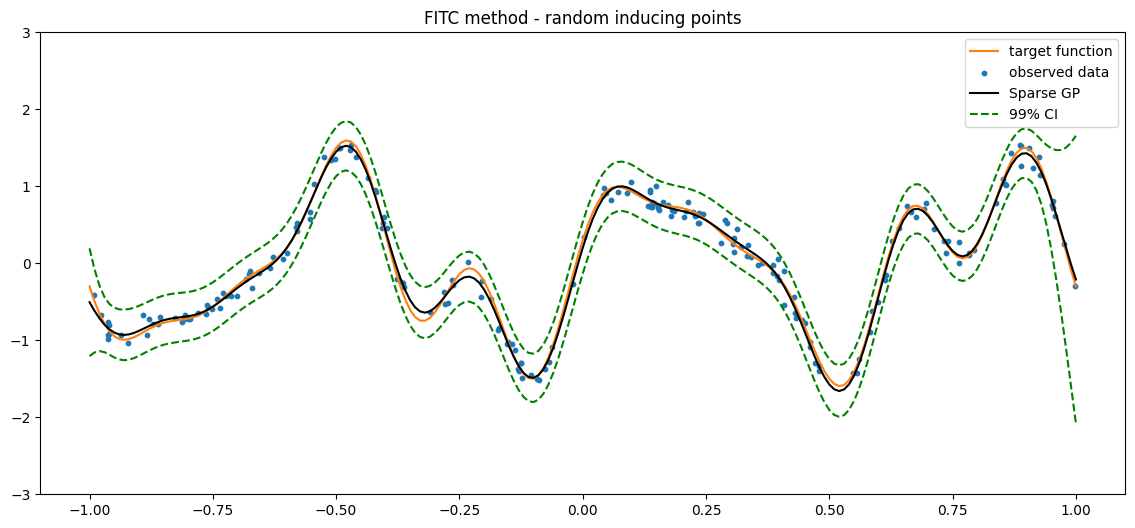

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(x, y, "C1-", label="target function")
plt.scatter(xt, yt, marker="o", s=10, label="observed data")
plt.plot(x, hat_y, "k-", label="Sparse GP")

plt.plot(x, hat_y - 3 * np.ravel(np.sqrt(var)), "g--")
plt.plot(x, hat_y + 3 * np.ravel(np.sqrt(var)), "g--", label="99% CI")
#plt.plot(Z1, -2.9 * np.ones_like(Z1), "r|", mew=2, label="inducing points - random")
plt.ylim([-3, 3])
plt.legend(loc=0)
plt.title('FITC method - random inducing points')
plt.show()

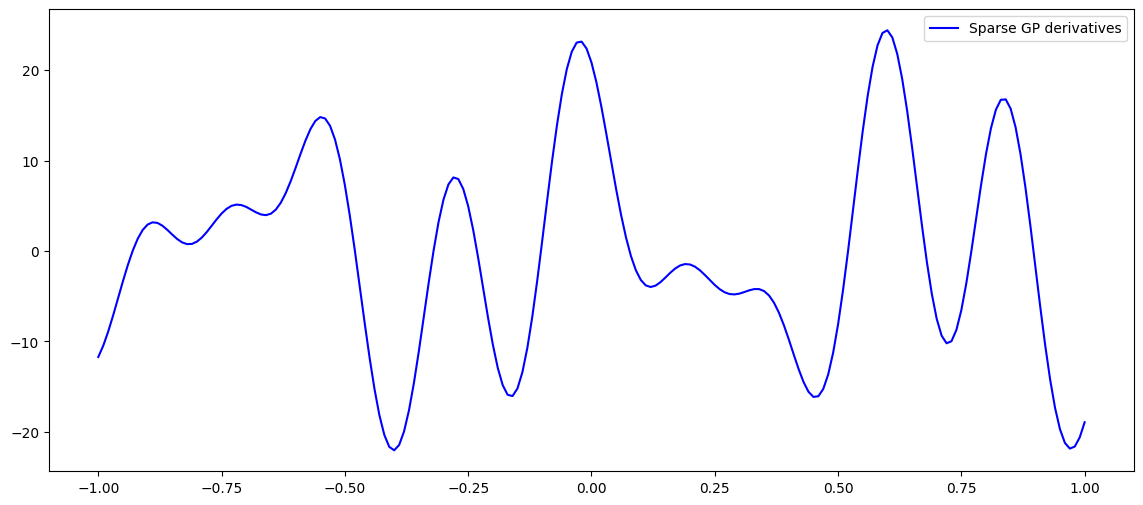

In [10]:
plt.figure(figsize=(14, 6))
plt.plot(x, d_hat_y, "b-", label="Sparse GP derivatives")
plt.legend(loc=0)
#plt.plot(x, var, "r.", label="Sparse GP")
#plt.plot(x, d_var, "r-", label="Sparse GP")

#### Sampling the conditionned Full Gaussian Process


In [11]:
# number fo trajectories to sample
n_traj = 30

trajs = sgpx.sample(x, n_traj)

#### Plotting trajectories

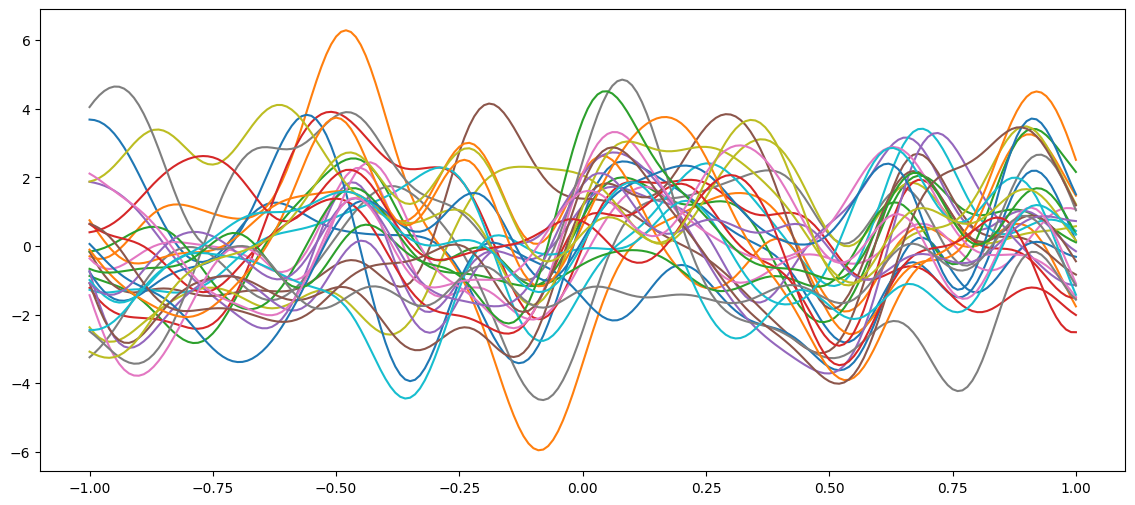

In [12]:
fig, axs = plt.subplots(1,figsize=(14, 6))

for i in range(n_traj):
    axs.plot(x, trajs[:, i])

plt.show()

## SparseGpx API

In [13]:
help(egx.SparseGpx.builder())

Help on SparseGpMix in module builtins object:

class SparseGpMix(object)
 |  SparseGpMix(corr_spec=Ellipsis, theta_init=None, theta_bounds=None, kpls_dim=None, n_start=10, nz=None, z=None, method=Ellipsis, seed=None)
 |  
 |  Sparse Gaussian processes mixture builder
 |  
 |  n_clusters (int >= 0)
 |      Number of clusters used by the mixture of surrogate experts.
 |      When set to 0, the number of cluster is determined automatically and refreshed every
 |      10-points addition (should say 'tentative addition' because addition may fail for some points
 |      but failures are counted anyway).
 |  
 |  corr_spec (CorrelationSpec flags, an int in [1, 15]):
 |      Specification of correlation models used in mixture.
 |      Can be CorrelationSpec.SQUARED_EXPONENTIAL (1), CorrelationSpec.ABSOLUTE_EXPONENTIAL (2),
 |      CorrelationSpec.MATERN32 (4), CorrelationSpec.MATERN52 (8) or
 |      any bit-wise union of these values (e.g. CorrelationSpec.MATERN32 | CorrelationSpec.MATERN52)


In [14]:
help(egx.SparseGpx)

Help on class SparseGpx in module builtins:

class SparseGpx(object)
 |  A trained Gaussian processes mixture
 |  
 |  Methods defined here:
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  __str__(self, /)
 |      Return str(self).
 |  
 |  likelihoods(self, /)
 |      Get reduced likelihood values gotten when fitting the GP experts
 |      
 |      Maybe used to compare various parameterization
 |      
 |      Returns
 |          likelihood as an array[n_clusters]
 |  
 |  predict(self, /, x)
 |      Predict output values at nsamples points.
 |      
 |      Parameters
 |          x (array[nsamples, nx])
 |              input values
 |      
 |      Returns
 |          the output values at nsamples x points (array[nsamples])
 |  
 |  predict_gradients(self, /, x)
 |      Predict surrogate output derivatives at nsamples points.
 |      
 |      Implementation note: central finite difference technique
 |      on `predict()` function is used which may be subject to numeri